<div>
<img style="float:left; border-radius:50%" src="https://avatars2.githubusercontent.com/u/58553327?s=460&u=3276252f07fb379c248bc8c9ce344bfdcaed7c45&v=4" width="40px">
<a href="https://github.com/carlosholivan"><img src="https://www.sferalabs.cc/wp-content/uploads/github-logo.png" width=70px style="float: right;"></a>
</div>

<a name="top"></a>

# CNN VAE <a name="top"></a>

In this notebook it is described how to compute different time-frequency inputs with <strong>compute_input_from_audiopath</strong> function.

Author: Carlos Hernández Oliván<br>
Last update: 7 November 2020
  

### Table of Contents <a name="index"></a>
 
1. [Short-Time Fourier Transform](#stft)
2. [Chroma from STFT](#chroma-stft)
3. [Constant Q-Transform](#cqt)
    
[References](#references)

In [1]:
import os

import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Our modules
#import sys
#sys.path.append('.')

from vae import configs, data_utils, train
from vae.model import VAE

In [3]:
torch.__version__

'1.7.1'

In [4]:
!lspci | grep -i nvidia

01:00.0 3D controller: NVIDIA Corporation GM107M [GeForce GTX 950M] (rev a2)


!sudo apt install nvidia-cuda-toolkit

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
!nvidia-smi

Wed Dec 16 11:12:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 950M    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0    N/A /  N/A |    354MiB /  4046MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Preprocessing data

In this part we'll create and store as .npy the audio representation we'd want to use as the input of our model.
The .npy files will be stored in data/ directory in our module and the name of the files will be the same as the audio files names.

In [ ]:
dataset_path = '/media/carlos/FILES/INVESTIGACION/Datasets/London Philarmonic Orchestra/'
store_inputs(dataset_path)

## 2. Create Dataloader from London Philarmonic Orchestra Dataset

In [8]:
# Dataloader
train_dataset = data_utils.AudioDataset(data_path=configs.ParamsConfig.DATA_PATH)
train_dataloader = DataLoader(train_dataset, batch_size=configs.ParamsConfig.BATCH_SIZE, num_workers=0)

val_dataset = data_utils.AudioDataset(data_path=configs.ParamsConfig.DATA_PATH)
val_dataloader = DataLoader(val_dataset, batch_size=configs.ParamsConfig.BATCH_SIZE, num_workers=0)

In [9]:
print('Number of files in the training dataset:', len(train_dataset))
print('Number of files in the training dataset:', len(val_dataset))

# Get a sample of the dataset
dataiter = iter(train_dataloader)
data = dataiter.next()
print(type(data))
print(data['file'])
print(data['input'].shape)

Number of files in the training dataset: 755
Number of files in the training dataset: 755
<class 'dict'>
['flute_Fs5_05_mezzo-forte_normal']
torch.Size([1, 1, 190, 70])


In [36]:
train_dataloader.__dict__

{'dataset': <vae.data_utils.AudioDataset at 0x7f9221a90070>,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 1,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x7f9223959a30>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f92239591c0>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

We can plot one sample of the dataset:

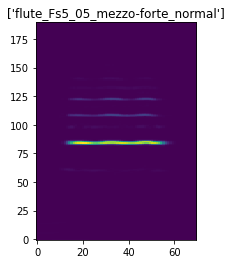

In [10]:
fig, ax = plt.subplots()
ax.imshow(data['input'][0, 0,...], cmap='viridis', interpolation='none', aspect=0.5, origin='lower')
ax.set_title(data['file'])
plt.show()

## 3. VAE Model

* How good is our reconstruction?
* Is the model architecture (kernels, layers...) good?
* How many latent dimensions do we need? 

<img src="https://theaisummer.com/assets/img/posts/Autoencoder/vae.png" width="500">

<img src="https://acids-ircam.github.io/variational-timbre/figures/logo.png" width="500">

In [11]:
# Model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Cuda available:', torch.cuda.is_available())
print('Selected device:', device)

model = VAE().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
print(model)

optimizer = optim.Adam(model.parameters(), lr=configs.ParamsConfig.LEARNING_RATE)
criterion = nn.BCELoss(reduction='sum')  # reconstruction loss

Cuda available: True
Selected device: cuda
Number of parameters: 276103
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 5), stride=(3, 1), padding=(1, 2))
    (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(1, 1))
    (pool1): AdaptiveMaxPool2d(output_size=(20, 1))
    (fc_mu): Linear(in_features=2560, out_features=3, bias=True)
    (fc_logvar): Linear(in_features=2560, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=3, out_features=2560, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(5, 3), stride=(3, 1), padding=(2, 1), dilation=(2, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(7, 5), stride=(3, 1), padding=(3, 2), dilation=(2, 1))
  )
)


In [12]:
from torchsummary import summary

channels = 1
h = data['input'].shape[2]
w = data['input'].shape[3]

summary(model, input_size=(channels, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 70]           2,304
            Conv2d-2          [-1, 128, 20, 70]         123,008
 AdaptiveMaxPool2d-3           [-1, 128, 20, 1]               0
            Linear-4                    [-1, 3]           7,683
            Linear-5                    [-1, 3]           7,683
           Encoder-6         [[-1, 3], [-1, 3]]               0
            Linear-7                 [-1, 2560]          10,240
   ConvTranspose2d-8           [-1, 64, 62, 70]         122,944
   ConvTranspose2d-9           [-1, 1, 190, 70]           2,241
          Decoder-10           [-1, 1, 190, 70]               0
Total params: 276,103
Trainable params: 276,103
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.85
Params size (MB): 1.05
Estimated T

<div>
    
<button type="button" class="btn btn-primary" style="float:left; background-color:#a273f9; border:0"><a href="#top" style="color:white; text-decoration: none">⇦ Back to Top</a></button>
    
</div>

## 4. RUN TRAINING<a name="training"></a>

In [13]:
train_loss = []
val_loss = []
train_kld = []
val_kld = []

if not os.path.exists(configs.ParamsConfig.TRAINED_MODELS_PATH):
    os.mkdir(configs.ParamsConfig.TRAINED_MODELS_PATH)

writer = SummaryWriter()

for epoch in range(configs.ParamsConfig.NUM_EPOCHS):
    print(f"Epoch {epoch+1} of {configs.ParamsConfig.NUM_EPOCHS}")
    train_epoch_loss, train_epoch_kld = train.fit(model, train_dataloader, device, optimizer, criterion)
    val_epoch_loss, val_epoch_kld = train.validate(model, val_dataloader, device, criterion)
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_kld.append(train_epoch_kld)
    val_kld.append(val_epoch_kld)
    
    # Tensorboard plots
    writer.add_scalars('Loss', {
                                'train': train_epoch_loss,
                                'val': val_epoch_loss
                                },
                       epoch)
    writer.add_scalar('Loss/train', train_epoch_kld, epoch)
    writer.add_scalar('Loss/train', val_epoch_kld, epoch)
    
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Train KLD: {train_epoch_kld:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    print(f"Val KLD: {val_epoch_kld:.4f}")
    
    #save trained model every 5 epochs
    if epoch % 1 == 0:
        torch.save(model.state_dict(), 
                   os.path.join(configs.ParamsConfig.TRAINED_MODELS_PATH, 'saved_model_' + str(epoch) + "epochs.bin"))

  0%|          | 2/755 [00:00<01:05, 11.54it/s]

Epoch 1 of 100


  0%|          | 2/755 [00:00<00:57, 13.08it/s]

Train Loss: 3359.8819
Train KLD: 0.0155
Val Loss: 4048.3855
Val KLD: 0.0156
Epoch 2 of 100


  0%|          | 0/755 [00:00<?, ?it/s]

Train Loss: 2917.6321
Train KLD: 0.0124
Val Loss: 3560.5391
Val KLD: 0.0124
Epoch 3 of 100


  0%|          | 2/755 [00:00<00:56, 13.29it/s]

Train Loss: 2824.1891
Train KLD: 0.0101
Val Loss: 1724.7931
Val KLD: 0.0101
Epoch 4 of 100


  0%|          | 2/755 [00:00<00:57, 13.18it/s]

Train Loss: 1243.1010
Train KLD: 0.0126
Val Loss: 975.6199
Val KLD: 0.0126
Epoch 5 of 100


100%|██████████| 755/755 [01:56<00:00,  6.47it/s]


Train Loss: -191.8939
Train KLD: 0.0112
Val Loss: 2128.0143
Val KLD: 0.0112


  0%|          | 2/755 [00:00<00:57, 13.14it/s]

Epoch 6 of 100


100%|██████████| 755/755 [01:56<00:00,  6.50it/s]


Train Loss: -446.1138
Train KLD: 0.0127
Val Loss: -338.2962
Val KLD: 0.0127


  0%|          | 2/755 [00:00<00:57, 13.17it/s]

Epoch 7 of 100


  0%|          | 2/755 [00:00<00:56, 13.26it/s]

Train Loss: 424.7183
Train KLD: 0.0089
Val Loss: -378.1842
Val KLD: 0.0089
Epoch 8 of 100


100%|██████████| 755/755 [01:56<00:00,  6.51it/s]


Train Loss: -1840.1033
Train KLD: 0.0117
Val Loss: 2741.1438
Val KLD: 0.0117


  0%|          | 2/755 [00:00<00:57, 13.00it/s]

Epoch 9 of 100


  0%|          | 2/755 [00:00<00:56, 13.29it/s]

Train Loss: -521.0966
Train KLD: 0.0132
Val Loss: -141.0464
Val KLD: 0.0133
Epoch 10 of 100


100%|██████████| 755/755 [01:56<00:00,  6.50it/s]


Train Loss: -2025.1533
Train KLD: 0.0120
Val Loss: 2778.2029
Val KLD: 0.0120


  0%|          | 2/755 [00:00<00:58, 12.94it/s]

Epoch 11 of 100


100%|██████████| 755/755 [01:56<00:00,  6.50it/s]


Train Loss: -27.9891
Train KLD: 0.0136
Val Loss: 3380.9225
Val KLD: 0.0136


  0%|          | 2/755 [00:00<00:54, 13.82it/s]

Epoch 12 of 100


100%|██████████| 755/755 [01:57<00:00,  6.41it/s]


Train Loss: -634.9070
Train KLD: 0.0187
Val Loss: -671.4496
Val KLD: 0.0187


  0%|          | 2/755 [00:00<00:57, 13.00it/s]

Epoch 13 of 100


  0%|          | 2/755 [00:00<00:54, 13.82it/s]

Train Loss: -2028.9036
Train KLD: 0.0160
Val Loss: -693.6759
Val KLD: 0.0160
Epoch 14 of 100


  0%|          | 2/755 [00:00<00:56, 13.32it/s]

Train Loss: -833.5247
Train KLD: 0.0175
Val Loss: -1425.3391
Val KLD: 0.0176
Epoch 15 of 100


  0%|          | 2/755 [00:00<00:54, 13.81it/s]

Train Loss: -2348.7128
Train KLD: 0.0155
Val Loss: 562.9654
Val KLD: 0.0155
Epoch 16 of 100


  0%|          | 2/755 [00:00<00:56, 13.38it/s]

Train Loss: -2131.7103
Train KLD: 0.0149
Val Loss: -2462.7192
Val KLD: 0.0149
Epoch 17 of 100


  0%|          | 2/755 [00:00<00:54, 13.82it/s]

Train Loss: -2830.7400
Train KLD: 0.0155
Val Loss: -1467.8811
Val KLD: 0.0155
Epoch 18 of 100


  0%|          | 2/755 [00:00<00:55, 13.53it/s]

Train Loss: -2522.3910
Train KLD: 0.0170
Val Loss: -2150.3924
Val KLD: 0.0170
Epoch 19 of 100


  0%|          | 2/755 [00:00<00:54, 13.69it/s]

Train Loss: -3041.3829
Train KLD: 0.0168
Val Loss: 549.2772
Val KLD: 0.0168
Epoch 20 of 100


  0%|          | 2/755 [00:00<00:55, 13.47it/s]

Train Loss: -2210.6599
Train KLD: 0.0145
Val Loss: -2429.6183
Val KLD: 0.0145
Epoch 21 of 100


  0%|          | 2/755 [00:00<00:54, 13.80it/s]

Train Loss: -3031.6523
Train KLD: 0.0140
Val Loss: -72.7664
Val KLD: 0.0140
Epoch 22 of 100


  0%|          | 2/755 [00:00<00:56, 13.37it/s]

Train Loss: -2942.7338
Train KLD: 0.0154
Val Loss: -2535.0639
Val KLD: 0.0154
Epoch 23 of 100


  0%|          | 2/755 [00:00<00:54, 13.82it/s]

Train Loss: -3206.4555
Train KLD: 0.0158
Val Loss: -2405.1020
Val KLD: 0.0158
Epoch 24 of 100


 51%|█████     | 385/755 [01:04<01:01,  5.98it/s]


KeyboardInterrupt: 

## 5. VISUALIZING LATENT SPACE<a name="visual"></a>

### 2 Latent Dimensions

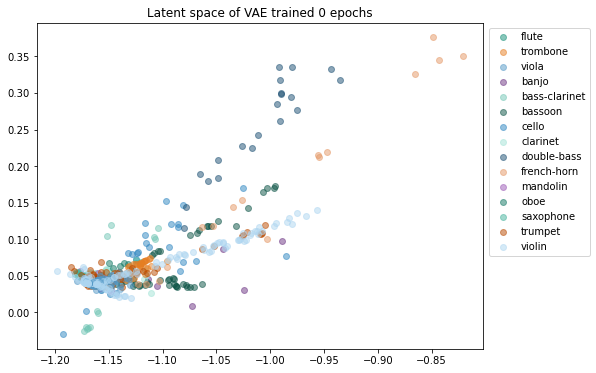

In [49]:
trained_epochs = "0" #load model trained this number of epochs


#Model loading
model = VAE()
model.load_state_dict(torch.load(configs.ParamsConfig.TRAINED_MODELS_PATH + '/saved_model_' + str(trained_epochs) + "epochs.bin"))
model.eval()


def plot_latent(model, data, save_plot=True):
    fig, ax = plt.subplots(figsize=(8, 6)) 
    plt.title('Latent space of VAE trained ' + trained_epochs + ' epochs')
    
    instruments = []
    for i, x in enumerate(data):
        z_mu, z_sigma = model.encoder(x['input']) #model.encoder(x['input'].to(device))      
        z = z_mu.to('cpu').detach().numpy()
        instrument = x['file'][0].split('_')[0]
        
        # If a point of an instrument family is already in the plot, do not add new legend
        if instrument not in instruments:
            label = instrument
        else:
            label = None
        ax.scatter(z[:, 0], z[:, 1], 
                    color=configs.PlotsConfig.COLORS.get(instrument), 
                    cmap='tab10', 
                    alpha=0.5,
                    label=label)
                 
        instruments.append(instrument)
        ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    
    if save_plot:
        if not os.path.exists(configs.PlotsConfig.PLOTS_PATH):
            os.mkdir(configs.PlotsConfig.PLOTS_PATH) 
        plt.savefig(configs.PlotsConfig.PLOTS_PATH + '/latent_space_' + trained_epochs + 'epochs.png')
            

plot_latent(model, train_dataloader)

In [85]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import Video
import numpy as np
import imageio
 

def update_graph(num):
    data=df_total[df_total['epoch']==num]
    graph.set_data(data.x, data.y)
    title.set_text('Latent space of epoch{}'.format(num))
    return title, graph,

def make_gif_latent_space(model, data, epochs=3, save_plot=True):
    
    trained_epochs = range(0, epochs) #load model trained this number of epochs
    #Model loading
    model = VAE()
    
    fig = plt.figure() 
    
    df_total = pd.DataFrame(columns=['epoch', 'x', 'y', 'instrument'])
    for epoch in trained_epochs:
        
        # Load trained model given the number of epochs trained
        model.load_state_dict(torch.load(configs.ParamsConfig.TRAINED_MODELS_PATH + '/saved_model_' + str(epoch) + "epochs.bin"))
        model.eval()
        
        instruments = []
        for i, x in enumerate(data):
            z_mu, z_sigma = model.encoder(x['input']) #model.encoder(x['input'].to(device))      
            z = z_mu.to('cpu').detach().numpy()
            instrument = x['file'][0].split('_')[0]        
            
            df_total = df_total.append({"epoch": epoch,
                                          "x" : z[:, 0], 
                                          "y" : z[:, 1], 
                                          "instrument": instrument}, ignore_index=True)
            
    data=df[df['epoch']==0]
    graph, = ax.plot(data.x, data.y)

    ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=400, blit=True)
    ani.save(configs.PlotsConfig.PLOTS_PATH + '/gif_latent_space.mp4')

    plt.show()
    
    """    
        ax.scatter(x, y, 
                    color=configs.PlotsConfig.COLORS.get(instrument), 
                    cmap='tab10', 
                    alpha=0.5,
                    label=label)

        ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    """
    print(df_total)

    return

make_gif_latent_space(model, train_dataloader)

KeyError: 'epoch'

<Figure size 432x288 with 0 Axes>

    time         x         y         z
0    0.0  9.687313  4.476761  4.378693
1    0.0  6.219984  9.870043  7.749157
2    0.0  3.698115  9.910476  4.330277
3    0.0  9.408257  8.500905  1.783604
4    0.0  8.635221  4.618026  0.731994
..   ...       ...       ...       ...
95   0.0  5.999581  2.418433  6.756126
96   0.0  5.104886  3.672010  0.195292
97   0.0  3.452767  4.096752  3.767615
98   0.0  1.605792  4.613592  3.964041
99   0.0  3.194003  5.056921  0.355702

[100 rows x 4 columns]


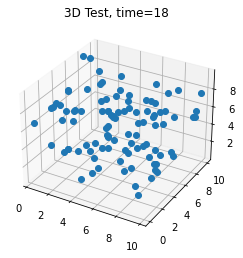

In [73]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=400, blit=True)
ani.save(configs.PlotsConfig.PLOTS_PATH + '/gif_latent_space.mp4')

plt.show()

### 3 Latent Dimensions

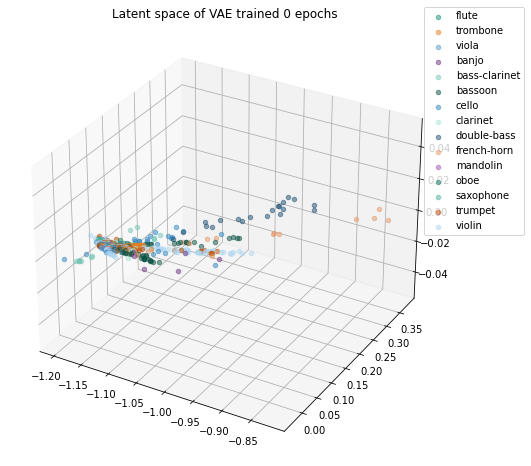

In [33]:
trained_epochs = "0" #load model trained this number of epochs


#Model loading
model = VAE()
model.load_state_dict(torch.load(configs.ParamsConfig.TRAINED_MODELS_PATH + '/saved_model_' + str(trained_epochs) + "epochs.bin"))
model.eval()
    

def plot_3_latent_dims(model, data, save_plot=True):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Latent space of VAE trained ' + trained_epochs + ' epochs')
    
    instruments = []
    for i, x in enumerate(data):
        z_mu, z_sigma = model.encoder(x['input']) #model.encoder(x['input'].to(device))      
        z = z_mu.to('cpu').detach().numpy()
        instrument = x['file'][0].split('_')[0]
        
        # If a point of an instrument family is already in the plot, do not add new legend
        if instrument not in instruments:
            label = instrument
        else:
            label = None
        ax.scatter(z[:, 0], z[:, 1], 
                    color=configs.PlotsConfig.COLORS.get(instrument), 
                    cmap='tab10', 
                    alpha=0.5,
                    label=label)
                 
        instruments.append(instrument)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
        ax.grid(True)
    
    if save_plot:
        if not os.path.exists(configs.PlotsConfig.PLOTS_PATH):
            os.mkdir(configs.PlotsConfig.PLOTS_PATH) 
        plt.savefig(configs.PlotsConfig.PLOTS_PATH + '/3d_latent_space_' + trained_epochs + 'epochs.png')
            

plot_3_latent_dims(model, train_dataloader)

## 6. GENERATING SAMPLES<a name="generating"></a>

In [ ]:
def sample_z(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    mu, sigma = args
    batch     = torch.shape(mu)[0]
    dim       = torch.int_shape(mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    eps       = torch.random_normal(shape=(batch, dim))
    return mu + torch.exp(sigma / 2) * eps

### References <a name="references"></a>

* Adam Lineberry: [GiHub](https://github.com/alineberry/alcore/blob/master/notebooks/VAE.ipynb) [Blog](http://adamlineberry.ai/vae-series/vae-code-experiments)

<div>
    
<button type="button" class="btn btn-primary" style="float:left; background-color:#a273f9; border:0"><a href="#top" style="color:white; text-decoration: none">⇦ Back to Top</a></button>

<button type="button" class="btn btn-primary" style="float:right; background-color:#BA55D3; border:0"><a href="2-chord_prediction.ipynb" style="color:white; text-decoration: none">Go to Chord Detection ⇒</a></button>
    
</div>